In [28]:
from utils import create_onedrive_directdownload
import sys

import numpy as np
import pandas as pd

import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

sys.path.append("..")

plt.style.use("ggplot")


In [5]:
onedrive_link = "https://1drv.ms/u/s!AiqdXCxPTydhoogp39Bwl0vnPA-ODQ?e=7PThrt"
converted_link = create_onedrive_directdownload(onedrive_link)
df = pd.read_csv(converted_link, parse_dates=True,
                 index_col="Month", skipfooter=2, engine='python')
df.head()


,Perrin Freres monthly champagne sales millions ?64-?72
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [6]:
df.columns = ["Sales"]


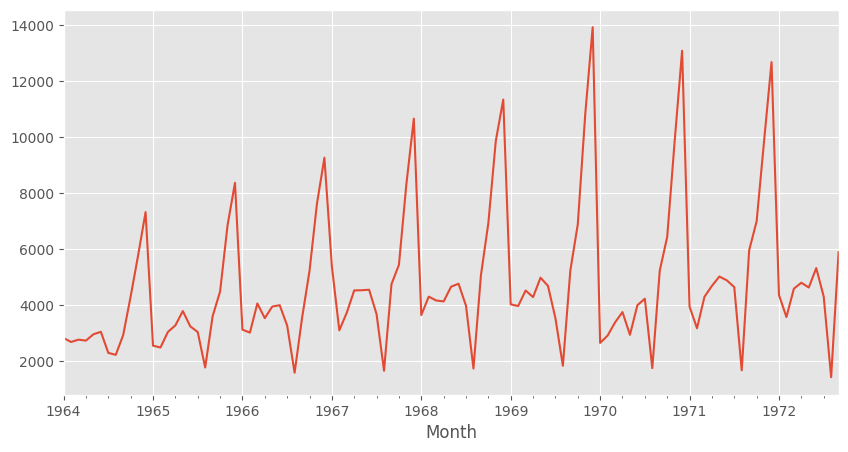

In [8]:
df["Sales"].plot(figsize=(10, 5))


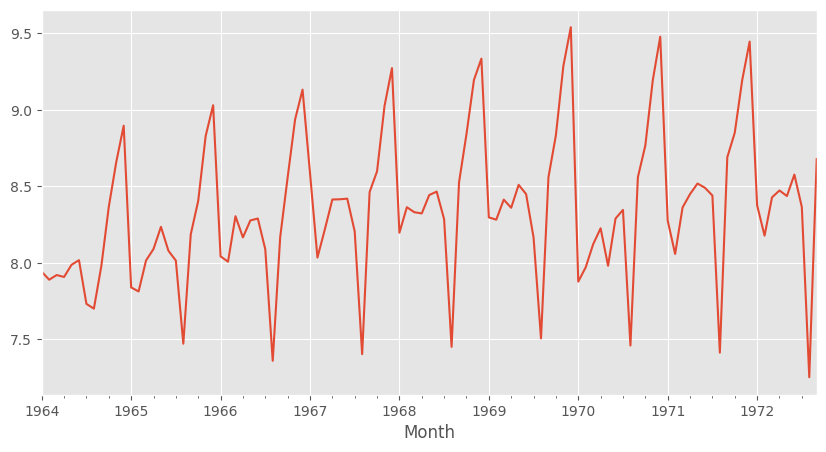

In [9]:
df["LogSales"] = np.log(df["Sales"])

df["LogSales"].plot(figsize=(10, 5))


In [10]:
df.index.freq = "MS"


In [11]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]


In [12]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]


In [14]:
model = pm.auto_arima(train["LogSales"],
                      trace=True,
                      suppress_warnings=True,
                      seasonal=True,
                      m=12
                      )


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=-50.146, Time=0.80 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-41.975, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-54.968, Time=0.24 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-53.384, Time=0.19 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-34.700, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-44.102, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-52.971, Time=0.47 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=-52.991, Time=0.38 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=-55.117, Time=0.21 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=-53.123, Time=0.42 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=-50.817, Time=0.19 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=-56.123, Time=0.23 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=-44.178, Time=0.05 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   

In [15]:
# Since the model is seasonal, we won't plot or predict the first 12
# values (since pmdarima) will set them to 0
train_pred = model.predict_in_sample(start=12, end=-1)
test_pred, conf_int = model.predict(n_periods=Ntest, return_conf_int=True)


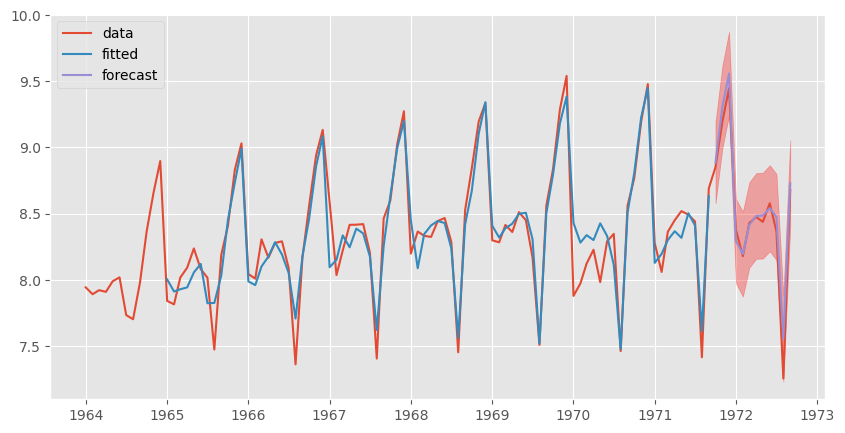

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.index, df["LogSales"], label="data")
ax.plot(train.index[12:], train_pred, label="fitted")
ax.plot(test.index, test_pred, label="forecast")
ax.fill_between(test.index, conf_int[:, 0],
                conf_int[:, 1], color="red", alpha=0.3)
ax.legend()
plt.show()


In [18]:
# compute the R^2
r2_score(test["Sales"], np.exp(test_pred))


0.9546973718838412

In [19]:
# Best non-seasonal model
model = pm.auto_arima(train["LogSales"], trace=True, max_p=12, max_q=2, max_order=14,
                      suppress_warning=True, stepwise=False, seasonal=False)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=141.911, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=141.540, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=139.851, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=138.023, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=114.336, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=114.576, Time=0.11 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=114.173, Time=0.08 

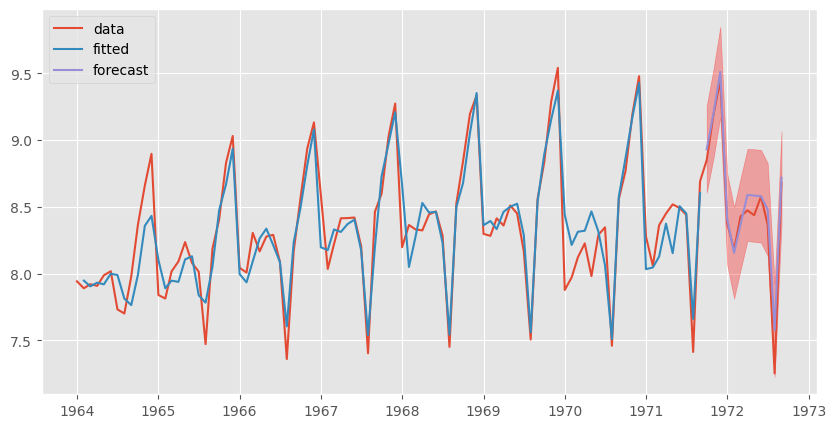

In [20]:
train_pred = model.predict_in_sample(start=1, end=-1)
test_pred, conf_int = model.predict(n_periods=Ntest, return_conf_int=True)

fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(df.index, df["LogSales"], label="data")
ax.plot(train.index[1:], train_pred, label="fitted")
ax.plot(test.index, test_pred, label="forecast")
ax.fill_between(test.index, conf_int[:,0], conf_int[:,1], color="red", alpha=0.3)
ax.legend()
plt.show()

In [21]:
r2_score(test["Sales"], np.exp(test_pred))

0.9728139879290886

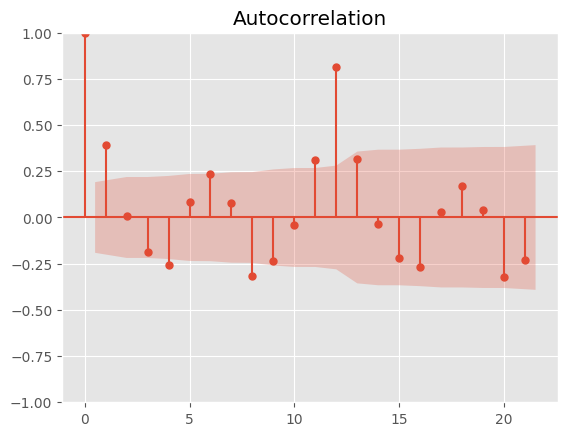

In [23]:
plot_acf(df["LogSales"]);

# q = 12

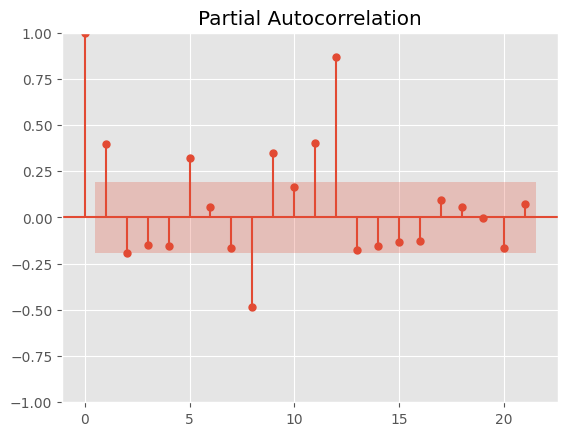

In [24]:
# You'll get a weird sqrt error with default method
plot_pacf(df["LogSales"], method="ols");

# p = 12

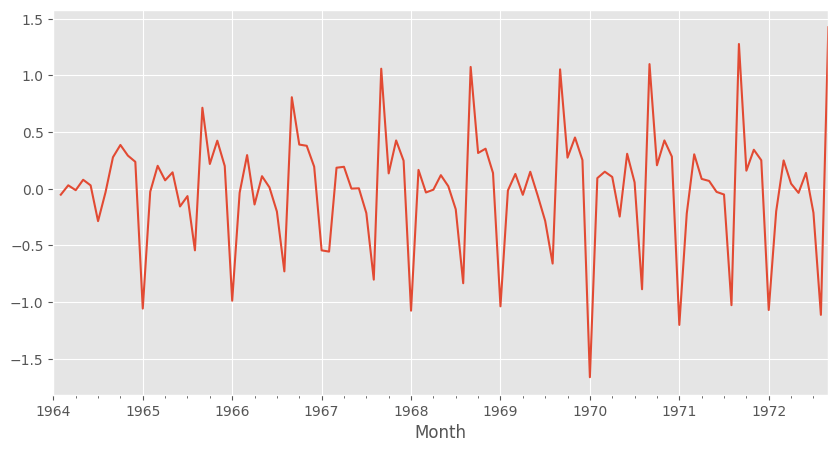

In [25]:
df["LogSales"].diff().plot(figsize=(10, 5));

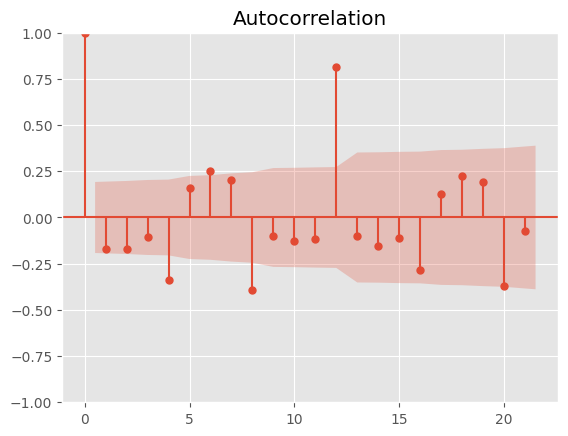

In [26]:
plot_acf(df["LogSales"].diff().dropna());

# q = 12

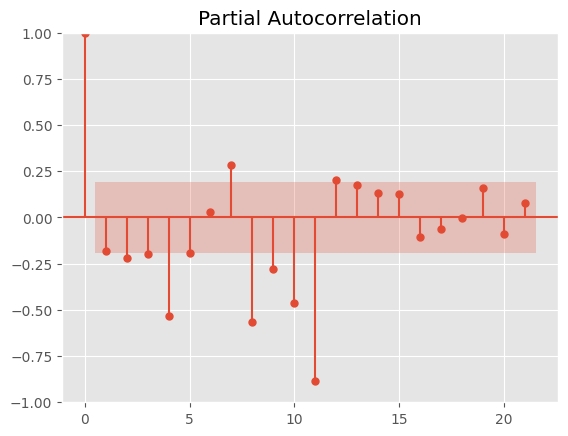

In [27]:
plot_pacf(df["LogSales"].diff().dropna(), method="ols");
# p = 11

In [29]:
adfuller(df["LogSales"])

# p-value > 5%. So, the time-series is not stationary.

(-2.2551186012844435,
 0.18685173111686743,
 13,
 91,
 {'1%': -3.50434289821397,
  '5%': -2.8938659630479413,
  '10%': -2.5840147047458037},
 -49.19143751582999)

In [30]:
adfuller(df["LogSales"].diff().dropna())

# p-value < 5%. So, the time series is stationary.

(-4.460914465253667,
 0.00023121404649532626,
 12,
 91,
 {'1%': -3.50434289821397,
  '5%': -2.8938659630479413,
  '10%': -2.5840147047458037},
 -43.63799632128658)

In [31]:
def plot_fit_and_forecast(result, d=0, col="Sales"):
    fig, ax = plt.subplots(figsize = (10, 5))
    ax.plot(df[col], label="data")

    # plot the curve fitted on train set
    train_pred = result.fittedvalues
    ax.plot(train.index[d:], train_pred[d:], color="green", label="fitted")

    # forecast the test set
    prediction_result = result.get_forecast(Ntest)
    conf_int = prediction_result.conf_int()
    lower, upper = conf_int[f"lower {col}"], conf_int[f"upper {col}"]
    forecast = prediction_result.predicted_mean
    ax.plot(test.index, forecast, label="forecast")
    ax.fill_between(test.index, lower, upper, color="red", alpha=0.3)
    ax.legend()
    return forecast

c:\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


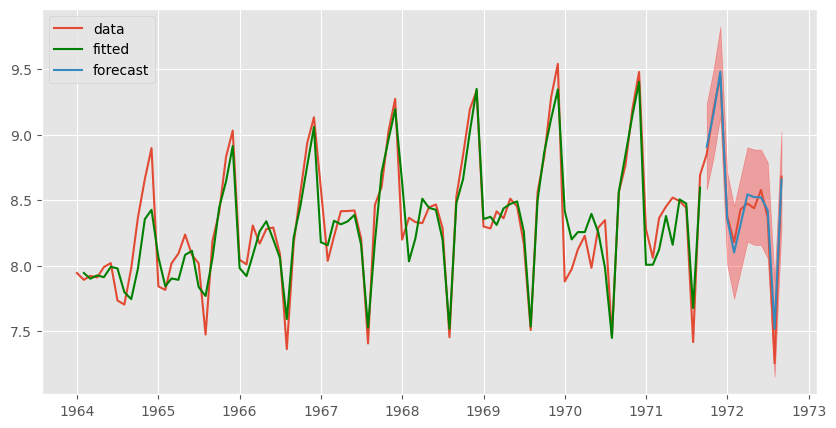

In [32]:
arima = ARIMA(train["LogSales"], order=(12, 1, 2))
arima_result = arima.fit()
forecast = plot_fit_and_forecast(arima_result, d=1, col="LogSales")

In [33]:
r2_score(test["Sales"], np.exp(forecast))

0.9855467300071162